In [41]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import desc
from pyspark.sql.functions import asc
from pyspark.sql.functions import sum as Fsum
from pyspark.sql import Window
from pyspark import SparkConf, SparkContext

import datetime

import numpy as np
import pandas as pd
import configparser

import pyspark

%matplotlib inline
import matplotlib.pyplot as plt

import findspark
findspark.init()

In [42]:
spark = SparkSession \
    .builder \
    .appName("Wrangling Data") \
    .getOrCreate()

In [43]:
path = "D:/OneDrive/Data Engineering/Udacity/Data Engineering/DataEngineering_Repo/Spark/sparkify_event_data.json"
user_log=spark.read.json(path)
user_log.take(5)

[Row(artist='Martin Orford', auth='Logged In', firstName='Joseph', gender='M', itemInSession=20, lastName='Morales', length=597.55057, level='free', location='Corpus Christi, TX', method='PUT', page='NextSong', registration=1532063507000, sessionId=292, song='Grand Designs', status=200, ts=1538352011000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='293'),
 Row(artist="John Brown's Body", auth='Logged In', firstName='Sawyer', gender='M', itemInSession=74, lastName='Larson', length=380.21179, level='free', location='Houston-The Woodlands-Sugar Land, TX', method='PUT', page='NextSong', registration=1538069638000, sessionId=97, song='Bulls', status=200, ts=1538352025000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='98'),
 Row(artist='Afroman', auth='Logged In', firstName='Maverick', gender='M', 

In [44]:
user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [45]:
user_log.describe("artist").show()

+-------+-----------------+
|summary|           artist|
+-------+-----------------+
|  count|           432877|
|   mean|527.5289537712895|
| stddev|966.1072451772757|
|    min|              !!!|
|    max|ÃÂlafur Arnalds|
+-------+-----------------+



In [46]:
user_log.describe("sessionId").show()

+-------+------------------+
|summary|         sessionId|
+-------+------------------+
|  count|            543705|
|   mean|2040.8143533717732|
| stddev|1434.3389310782666|
|    min|                 1|
|    max|              4808|
+-------+------------------+



In [47]:
user_log.count()

543705

In [48]:
user_log.select("page").dropDuplicates().sort("page").show()

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|               Login|
|              Logout|
|            NextSong|
|            Register|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
| Submit Registration|
|      Submit Upgrade|
|         Thumbs Down|
+--------------------+
only showing top 20 rows



In [49]:
user_log.select(["userId","firstname","page","song"]).where(user_log.userId == "295").collect()

[Row(userId='295', firstname='Alyssa', page='Home', song=None),
 Row(userId='295', firstname='Alyssa', page='NextSong', song='Almaz'),
 Row(userId='295', firstname='Alyssa', page='NextSong', song='Only Lonely'),
 Row(userId='295', firstname='Alyssa', page='Add to Playlist', song=None),
 Row(userId='295', firstname='Alyssa', page='NextSong', song='Love You Down'),
 Row(userId='295', firstname='Alyssa', page='NextSong', song="Hailie's Song"),
 Row(userId='295', firstname='Alyssa', page='NextSong', song="I've Got That Old Feeling"),
 Row(userId='295', firstname='Alyssa', page='Add to Playlist', song=None),
 Row(userId='295', firstname='Alyssa', page='NextSong', song="The Remedy (I Won't Worry) (New EQ'd LP Version)"),
 Row(userId='295', firstname='Alyssa', page='NextSong', song='Our Farewell (Album Version)'),
 Row(userId='295', firstname='Alyssa', page='NextSong', song="I'd Like To Walk Around In Your Mind"),
 Row(userId='295', firstname='Alyssa', page='NextSong', song='SinceritÃ\x83Â© E

In [50]:
# Get hour from ts column

get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x /1000.0).hour)
user_log = user_log.withColumn("hour", get_hour(user_log.ts))

In [51]:
user_log.head()

Row(artist='Martin Orford', auth='Logged In', firstName='Joseph', gender='M', itemInSession=20, lastName='Morales', length=597.55057, level='free', location='Corpus Christi, TX', method='PUT', page='NextSong', registration=1532063507000, sessionId=292, song='Grand Designs', status=200, ts=1538352011000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='293', hour='2')

In [52]:
songs_in_hour = user_log.filter(user_log.page == "NextSong").groupby(user_log.hour).count().orderBy(user_log.hour.cast("float"))
songs_in_hour.show()

+----+-----+
|hour|count|
+----+-----+
|   0|18758|
|   1|17657|
|   2|17425|
|   3|16569|
|   4|15862|
|   5|15420|
|   6|15386|
|   7|15130|
|   8|15116|
|   9|15016|
|  10|15258|
|  11|15427|
|  12|16021|
|  13|16751|
|  14|17773|
|  15|19025|
|  16|21088|
|  17|22255|
|  18|22204|
|  19|22564|
+----+-----+
only showing top 20 rows



In [53]:
# Transform Spark dataframe to Pandas

songs_in_hour_pd = songs_in_hour.toPandas()

Text(0, 0.5, 'Songs played')

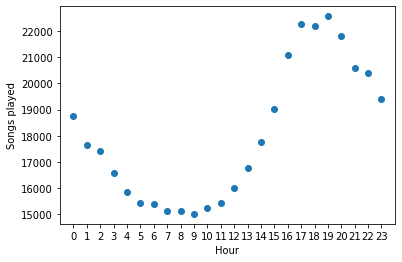

In [54]:
plt.scatter(songs_in_hour_pd["hour"], songs_in_hour_pd["count"])
plt.xlim(-1, 24)
plt.xlabel("Hour")
plt.ylabel("Songs played")

In [55]:
# Drop missing values
user_log_valid = user_log.dropna(how = "any", subset= ["userId", "sessionId"])
user_log_valid.count()

543705

In [56]:
# Look at the user ids
user_log.select("userId").dropDuplicates().sort("userId").show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows



In [57]:
# Remove records with "" as userId
 
user_log_valid = user_log_valid.filter(user_log_valid["userId"] != "")
user_log_valid.count()

528005

In [58]:
# Find users downgrading their account level
user_log_valid.filter("page = 'Submit Downgrade'").show()

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+----+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|            page| registration|sessionId|song|status|           ts|           userAgent|userId|hour|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+----+
|  null|Logged In|   Carter|     M|          117|    Cook|  null| paid|Chicago-Napervill...|   PUT|Submit Downgrade|1522793334000|      287|null|   307|1538382247000|"Mozilla/5.0 (iPh...|   288|  10|
|  null|Logged In|   Aurora|     F|          105|Humphrey|  null| paid|Dallas-Fort Worth...|   PUT|Submit Downgrade|1536795126000|      537|null|   307|1538447915000|"Mozilla/5.0 (Win...|   127|   4|


In [59]:
user_log.select(["userId","firstname","page","song"]).where(user_log.userId == "226").collect()

[Row(userId='226', firstname='Sadie', page='NextSong', song='Greece 2000'),
 Row(userId='226', firstname='Sadie', page='NextSong', song='Sick Bubblegum (Explicit Album Version)'),
 Row(userId='226', firstname='Sadie', page='NextSong', song='Tive Sim'),
 Row(userId='226', firstname='Sadie', page='NextSong', song='Noise'),
 Row(userId='226', firstname='Sadie', page='Downgrade', song=None),
 Row(userId='226', firstname='Sadie', page='NextSong', song='Mockingbird'),
 Row(userId='226', firstname='Sadie', page='NextSong', song='Duas LÃ\x83Â¡grimas De Orvalho'),
 Row(userId='226', firstname='Sadie', page='Add to Playlist', song=None),
 Row(userId='226', firstname='Sadie', page='NextSong', song="Say It Ain't So"),
 Row(userId='226', firstname='Sadie', page='NextSong', song='Secrets'),
 Row(userId='226', firstname='Sadie', page='NextSong', song='Barely Breathing (LP Version)'),
 Row(userId='226', firstname='Sadie', page='NextSong', song='Pointless Nostalgic'),
 Row(userId='226', firstname='Sadi

In [60]:
flag_downgrade_event = udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())

In [61]:
# Find users who have downgraded their account

user_log_valid = user_log_valid.withColumn("downgraded", flag_downgrade_event("page"))
user_log_valid.head()

Row(artist='Martin Orford', auth='Logged In', firstName='Joseph', gender='M', itemInSession=20, lastName='Morales', length=597.55057, level='free', location='Corpus Christi, TX', method='PUT', page='NextSong', registration=1532063507000, sessionId=292, song='Grand Designs', status=200, ts=1538352011000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='293', hour='2', downgraded=0)

In [62]:
windowval = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)
user_log_valid = user_log_valid.withColumn("phase", Fsum("downgraded").over(windowval))
user_log_valid.select(["userId","firstname","ts","page","level","phase"]).where(user_log.userId == "226").sort("ts").collect()

[Row(userId='226', firstname='Sadie', ts=1538509860000, page='NextSong', level='paid', phase=1),
 Row(userId='226', firstname='Sadie', ts=1538510271000, page='NextSong', level='paid', phase=1),
 Row(userId='226', firstname='Sadie', ts=1538510495000, page='NextSong', level='paid', phase=1),
 Row(userId='226', firstname='Sadie', ts=1538510622000, page='NextSong', level='paid', phase=1),
 Row(userId='226', firstname='Sadie', ts=1538510651000, page='Downgrade', level='paid', phase=1),
 Row(userId='226', firstname='Sadie', ts=1538510856000, page='NextSong', level='paid', phase=1),
 Row(userId='226', firstname='Sadie', ts=1538511106000, page='NextSong', level='paid', phase=1),
 Row(userId='226', firstname='Sadie', ts=1538511118000, page='Add to Playlist', level='paid', phase=1),
 Row(userId='226', firstname='Sadie', ts=1538511263000, page='NextSong', level='paid', phase=1),
 Row(userId='226', firstname='Sadie', ts=1538511523000, page='NextSong', level='paid', phase=1),
 Row(userId='226', fir